In [1]:
import pandas as pd
import numpy as np
import os

#dict_emb = 'ru'
dict_emb = 'ru-eng'

X_fake = np.hstack([np.load(dict_emb + '/fake/text_d2v.npy'), np.load(dict_emb + '/fake/text_lda.npy')])
X_true = np.hstack([np.load(dict_emb + '/true/text_d2v.npy'), np.load(dict_emb + '/true/text_lda.npy')])
X_eng = np.hstack([np.load(dict_emb + '/eng/text_d2v.npy'), np.load(dict_emb + '/eng/text_lda.npy')])

y_fake = np.load(dict_emb + '/fake/y.npy')
y_true = np.load(dict_emb + '/true/y.npy')
y_eng = np.load(dict_emb + '/eng/y.npy')

X_fake_title = np.nan_to_num(np.load(dict_emb + '/fake/title_w2v.npy'))
X_true_title = np.nan_to_num(np.load(dict_emb + '/true/title_w2v.npy'))
X_eng_title = np.nan_to_num(np.load(dict_emb + '/eng/title_w2v.npy'))

def sim(x, y):
    return np.sum(x * y, axis=1) / (np.linalg.norm(x, axis=1) * np.linalg.norm(y, axis=1) +1e-5)

def dist(x, y):
    return np.linalg.norm(x - y, axis=1)


sim_fake, dist_fake = sim(X_fake[:, :64], X_fake_title)[:, None], dist(X_fake[:, :64], X_fake_title)[:, None]
sim_true, dist_true = sim(X_true[:, :64], X_true_title)[:, None], dist(X_true[:, :64], X_true_title)[:, None]
sim_eng, dist_eng = sim(X_eng[:, :64], X_eng_title)[:, None], dist(X_eng[:, :64], X_eng_title)[:, None]

X_fake = np.hstack([X_fake, sim_fake, dist_fake])
X_true = np.hstack([X_true, sim_true, dist_true])
X_eng = np.hstack([X_eng, sim_eng, dist_eng])

In [2]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split


def prepare(num_true, num_eng, test_size):
    X_eng_tr, X_eng_te, y_eng_tr, y_eng_te = train_test_split(X_eng, y_eng, train_size=num_eng)
    X_true_s, _, y_true_s, _ = train_test_split(X_true, y_true, train_size=num_true)
    
    X_rus, X_test, y_rus, y_test = train_test_split(np.vstack([X_fake, X_true_s]),
                                                    np.concatenate([y_fake, y_true_s]), 
                                                    test_size=test_size)
    
    X_train = np.vstack([X_eng_tr, X_rus])
    y_train = np.concatenate([y_eng_tr, y_rus])
    return X_train, X_test, X_eng_te, y_train, y_test, y_eng_te

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import trange
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [4]:
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_test, y_test, batchsize=32, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 64

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        print("Epoch {} error = {:.2%}".format(epoch, 1 - val_acc_log[-1][1]))
            
    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))
    return val_acc_log
    
    
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rnn_l = nn.LSTM(64, 64, num_layers=2, dropout=0.2)
        self.rnn_r = nn.LSTM(64, 64, num_layers=2, dropout=0.2)
        
        self.clf = nn.Sequential(
            nn.Linear(130, 32),
            nn.ReLU(True),
            nn.BatchNorm1d(32),
            nn.Linear(32, 8),
            nn.ReLU(True),
            nn.BatchNorm1d(8),
            nn.Linear(8, 2)
        )
        
        
    def forward(self, x):
        x = x.reshape((-1, 1, 130))
        
        lstm_out_l, _ = self.rnn_l(x[:, :, :64])
        lstm_out_r, _ = self.rnn_r(x[:, :, 64:128])
        lstm_out = torch.cat([lstm_out_l, lstm_out_r, x[:, :, 128:]], dim=2)
        out = self.clf(lstm_out.reshape((-1, 130)))
        return F.log_softmax(out, dim=-1)
    
model = Net()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 137674


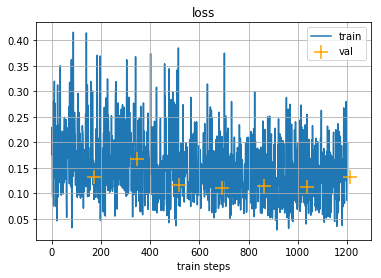

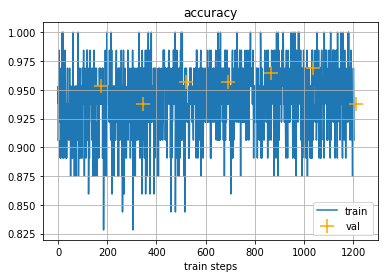

Epoch 6 error = 6.25%
Final error: 6.25%
CPU times: user 55min 10s, sys: 1h 44min 10s, total: 2h 39min 20s
Wall time: 20min 51s


In [6]:
%%time
import warnings
warnings.filterwarnings('ignore')


res0 = []
for i in range(5):
    X_train, X_test, X_eng_te, y_train, y_test, y_eng_te = prepare(500, 10000, 0.2)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    res0.append(train(model, opt, 7))

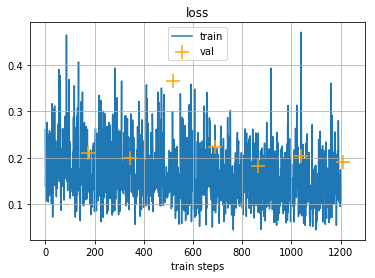

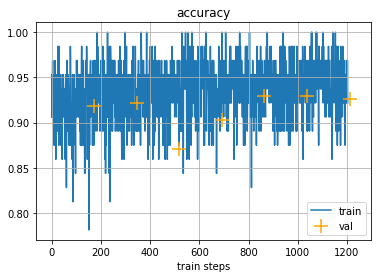

Epoch 6 error = 7.42%
Final error: 7.42%


In [7]:
class Net_no_lda(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rnn = nn.LSTM(64, 64, num_layers=2, dropout=0.2)
        
        self.clf = nn.Sequential(
            nn.Linear(66, 32),
            nn.ReLU(True),
            nn.BatchNorm1d(32),
            nn.Linear(32, 8),
            nn.ReLU(True),
            nn.BatchNorm1d(8),
            nn.Linear(8, 2)
        )
        
        
    def forward(self, x):
        x = x.reshape((-1, 1, 130))
        
        lstm_out, _ = self.rnn(x[:, :, :64])
        lstm_out = torch.cat([lstm_out, x[:, :, 128:]], dim=2)
        out = self.clf(lstm_out.reshape((-1, 66)))
        return F.log_softmax(out, dim=-1)
    
model = Net_no_lda()
print("Total number of trainable parameters:", count_parameters(model))
res1 = []
for i in range(5):
    X_train, X_test, X_eng_te, y_train, y_test, y_eng_te = prepare(500, 10000, 0.2)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    res1.append(train(model, opt, 7))

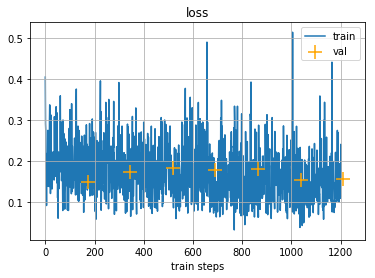

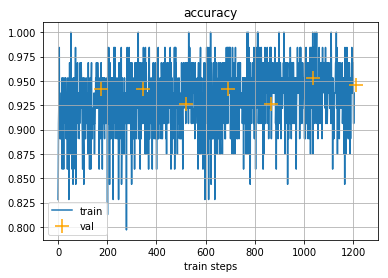

Epoch 6 error = 5.47%
Final error: 5.47%


In [8]:
class Net_d2v(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rnn = nn.LSTM(64, 64, num_layers=2, dropout=0.2)
        
        self.clf = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.BatchNorm1d(32),
            nn.Linear(32, 8),
            nn.ReLU(True),
            nn.BatchNorm1d(8),
            nn.Linear(8, 2)
        )
        
        
    def forward(self, x):
        x = x.reshape((-1, 1, 130))
        
        lstm_out, _ = self.rnn(x[:, :, :64])
        out = self.clf(lstm_out.reshape((-1, 64)))
        return F.log_softmax(out, dim=-1)
    
model = Net_d2v()
print("Total number of trainable parameters:", count_parameters(model))
res2 = []
for i in range(5):
    X_train, X_test, X_eng_te, y_train, y_test, y_eng_te = prepare(500, 10000, 0.2)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    res2.append(train(model, opt, 7))

In [17]:
print(np.max(np.sum(np.array(res0)[:, :, 1], axis=0) / 5))
print(np.max(np.sum(np.array(res1)[:, :, 1], axis=0) / 5))
print(np.max(np.sum(np.array(res2)[:, :, 1], axis=0) / 5))

0.9375
0.9
0.9109375


In [ ]:
np.max(np.sum(np.array(res0)[:, :, 1], axis=0) / 5)